<h1 style="color: #6485DB;">Problem Statement</h1>
<hr>

### Overview
This is a binary classification problem where you need to predict whether an ad buy will lead to a netgain.

### Data Description
**train.csv**<br>
It contains the training data with advertisement details as described in the last section

**test.csv**<br>
It has advertisement details for which the participants are to submit whether netgain would be there

**Data Dictionary**

|Variable                          |Description|
|:---------------------------------|:-----------|
|UserID                            |Unique id for each row|
|ratings                           |Metric out of 1 which represents how much of the targeted demographic watched the advertisement|
|airlocation                       |Country of origin|
|airtime	                       |Time when the advertisement was aired|
|average_runtime(minutes_per_week) |Minutes per week the advertisement was aired|
|targeted_sex                      |Sex that was mainly targeted for the advertisement|
|genre	                           |The type of advertisement|
|industry                          |The industry to which the product belonged|
|relationship_status               |The relationship status of the most responsive customers to the advertisement|
|expensive	                       |A general measure of how expensive the product or service is that the ad is discussing|
|money_back_guarantee	           |Whether or not the product offers a refund in the case of customer dissatisfaction|
|netgain                           |Target, Whether the ad will incur a gain or loss when sold|

<hr>

## Table of contents <a name="table_of_contents"></a>
1. [Importing Important Libraries](#importing_libraries)
2. [Loading the Data](#load_data)
3. [Data Visualization](#data_visual)
4. [Encoding training data](#encoding_train)
5. [Split Data using Train_Test_Split](#splitting)
6. [Model Building](#model_building)
    1. [Using Logistic Regression](#logistic_regression)
    2. [Using Decision Tree Classifier](#decision_tree_classifier)
    3. [Using CatBoost Classifier](#catboost_classifier)
    4. [Using XGBoost Classifier](#xgboost_classifier)
7. [Metrics Comparison](#metrics_comparison)
8. [Read and Encode Test Data](#read_test_data)
9. [Generating Predictions](#predictions)

## 1. Import Important Libraries <a name="importing_libraries"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


## 2. Loading the data <a name="load_data"></a>

In [2]:
train_df = pd.read_csv("data/train.csv")
train_df.head()

,UserID,realtionship_status,industry,genre,targeted_sex,average_runtime(minutes_per_week),airtime,airlocation,ratings,expensive,money_back_guarantee,netgain
0,UI_9185,Married-civ-spouse,Pharma,Comedy,Male,40,Daytime,United-States,0.027465,Medium,No,0
1,UI_449,Never-married,Political,Comedy,Male,35,Morning,International,0.027465,Low,No,0
2,UI_9014,Never-married,Auto,Comedy,Male,40,Morning,United-States,0.027465,Low,No,0
3,UI_14987,Married-civ-spouse,Pharma,Infomercial,Male,40,Primetime,United-States,0.027465,Low,Yes,0
4,UI_25532,Married-civ-spouse,Other,Comedy,Female,50,Primetime,United-States,0.027465,Low,Yes,1


In [3]:
train_df.shape

(19536, 12)

In [4]:
train_df.describe()

,average_runtime(minutes_per_week),ratings,netgain
count,19536.000000,19536.000000,19536.000000
mean,40.375665,0.038826,0.238022
std,12.483166,0.075971,0.425884
min,1.000000,0.000000,0.000000
25%,40.000000,0.027465,0.000000
50%,40.000000,0.027465,0.000000
75%,45.000000,0.027465,0.000000
max,99.000000,1.000000,1.000000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19536 entries, 0 to 19535
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   UserID                             19536 non-null  object 
 1   realtionship_status                19536 non-null  object 
 2   industry                           19536 non-null  object 
 3   genre                              19536 non-null  object 
 4   targeted_sex                       19536 non-null  object 
 5   average_runtime(minutes_per_week)  19536 non-null  int64  
 6   airtime                            19536 non-null  object 
 7   airlocation                        19536 non-null  object 
 8   ratings                            19536 non-null  float64
 9   expensive                          19536 non-null  object 
 10  money_back_guarantee               19536 non-null  object 
 11  netgain                            19536 non-null  int

In [6]:
# Rename the column 'realtionship_status' to 'relationship_status' to use further it without trouble.
train_df.rename(columns={'realtionship_status':'relationship_status'}, inplace=True)
train_df.relationship_status.unique()

array(['Married-civ-spouse', 'Never-married', 'Divorced', 'Separated',
       'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [7]:
# Check for any missing data
train_df.isnull().sum()

UserID                               0
relationship_status                  0
industry                             0
genre                                0
targeted_sex                         0
average_runtime(minutes_per_week)    0
airtime                              0
airlocation                          0
ratings                              0
expensive                            0
money_back_guarantee                 0
netgain                              0
dtype: int64

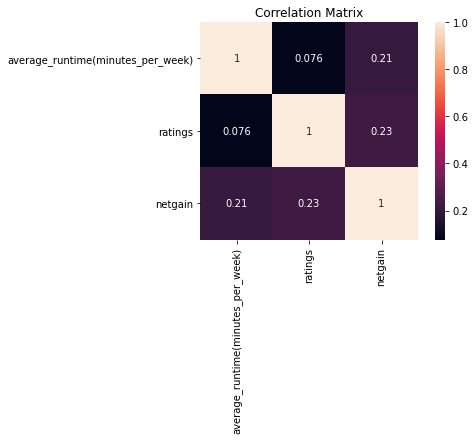

In [8]:
# Let's check the correlation matrix between numerical columns
corr = train_df.corr()
sns.heatmap(corr, annot=True, square=True)
plt.title("Correlation Matrix", fontsize=12)
plt.show()

In [9]:
# Check all unique values for all the categorical columns
for col in train_df:
    if(train_df[col].dtypes == object):
        print(col," - ",train_df[col].unique())

UserID  -  ['UI_9185' 'UI_449' 'UI_9014' ... 'UI_9846' 'UI_10800' 'UI_2733']
relationship_status  -  ['Married-civ-spouse' 'Never-married' 'Divorced' 'Separated' 'Widowed'
 'Married-spouse-absent' 'Married-AF-spouse']
industry  -  ['Pharma' 'Political' 'Auto' 'Other' 'Entertainment' 'ClassAction']
genre  -  ['Comedy' 'Infomercial' 'Drama' 'Direct' 'Other']
targeted_sex  -  ['Male' 'Female']
airtime  -  ['Daytime' 'Morning' 'Primetime']
airlocation  -  ['United-States' 'International' 'Mexico' 'Hong' 'Cuba' 'Germany' 'India'
 'Iran' 'Dominican-Republic' 'Philippines' 'Japan' 'Italy' 'South'
 'Poland' 'Vietnam' 'Columbia' 'Outlying-US(Guam-USVI-etc)' 'Puerto-Rico'
 'Hungary' 'El-Salvador' 'England' 'Taiwan' 'Canada' 'France' 'Guatemala'
 'Thailand' 'China' 'Jamaica' 'Portugal' 'Haiti' 'Yugoslavia' 'Nicaragua'
 'Honduras' 'Trinadad&Tobago' 'Ireland' 'Laos' 'Cambodia' 'Ecuador' 'Peru'
 'Scotland' 'Greece' 'Holand-Netherlands']
expensive  -  ['Medium' 'Low' 'High']
money_back_guarantee  -  

In [10]:
# Removing the entry with airlocation 'Trinadad&Tobago' as it is not in Test data, and would result in error while prediction
train_df = train_df[train_df.airlocation != 'Trinadad&Tobago']
train_df.airlocation.unique()

array(['United-States', 'International', 'Mexico', 'Hong', 'Cuba',
       'Germany', 'India', 'Iran', 'Dominican-Republic', 'Philippines',
       'Japan', 'Italy', 'South', 'Poland', 'Vietnam', 'Columbia',
       'Outlying-US(Guam-USVI-etc)', 'Puerto-Rico', 'Hungary',
       'El-Salvador', 'England', 'Taiwan', 'Canada', 'France',
       'Guatemala', 'Thailand', 'China', 'Jamaica', 'Portugal', 'Haiti',
       'Yugoslavia', 'Nicaragua', 'Honduras', 'Ireland', 'Laos',
       'Cambodia', 'Ecuador', 'Peru', 'Scotland', 'Greece',
       'Holand-Netherlands'], dtype=object)

## 3. Data Visualization <a name="data_visual"></a>

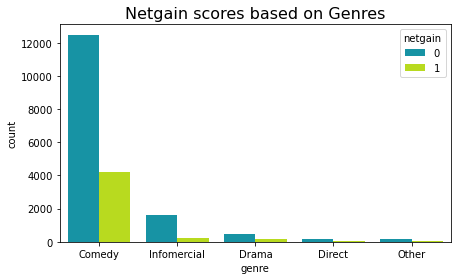

------------------------------------------------------------


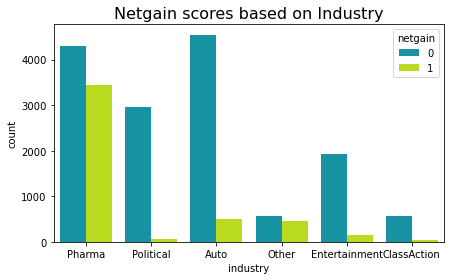

------------------------------------------------------------


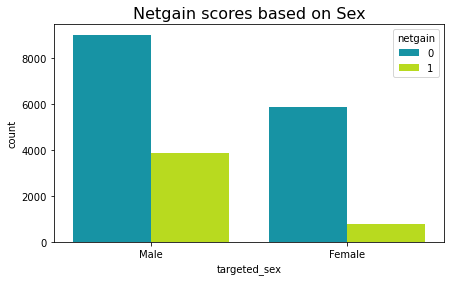

------------------------------------------------------------


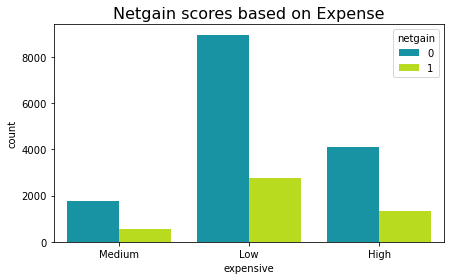

------------------------------------------------------------


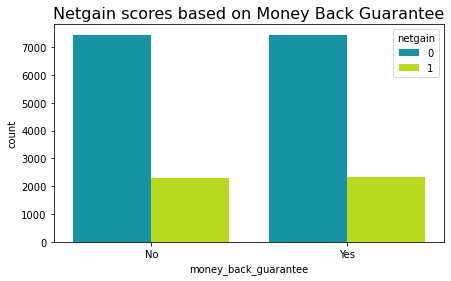

In [11]:
# Compare netgain distribution based on different categorical columns

plt.figure(figsize=(7,4))
sns.countplot(train_df.genre, hue=train_df.netgain, palette="nipy_spectral")
plt.title("Netgain scores based on Genres", fontsize=16)
plt.show()
print("---"*20)

plt.figure(figsize=(7,4))
sns.countplot(train_df.industry, hue=train_df.netgain, palette="nipy_spectral")
plt.title("Netgain scores based on Industry", fontsize=16)
plt.show()
print("---"*20)

plt.figure(figsize=(7,4))
sns.countplot(train_df.targeted_sex, hue=train_df.netgain, palette="nipy_spectral")
plt.title("Netgain scores based on Sex", fontsize=16)
plt.show()
print("---"*20)

plt.figure(figsize=(7,4))
sns.countplot(train_df.expensive, hue=train_df.netgain, palette="nipy_spectral")
plt.title("Netgain scores based on Expense", fontsize=16)
plt.show()
print("---"*20)

plt.figure(figsize=(7,4))
sns.countplot(train_df.money_back_guarantee, hue=train_df.netgain, palette="nipy_spectral")
plt.title("Netgain scores based on Money Back Guarantee", fontsize=16)
plt.show()

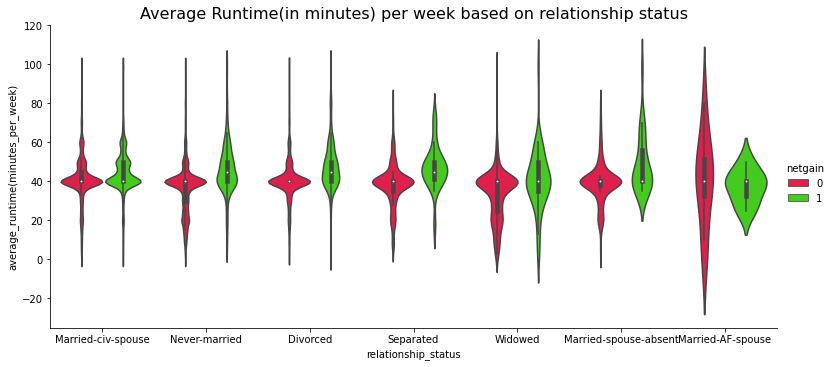

In [12]:
sns.catplot(data=train_df, x='relationship_status', y='average_runtime(minutes_per_week)', hue='netgain', 
            palette="prism_r" , kind='violin', aspect=2.2)
plt.title("Average Runtime(in minutes) per week based on relationship status", fontsize=16)
plt.show()

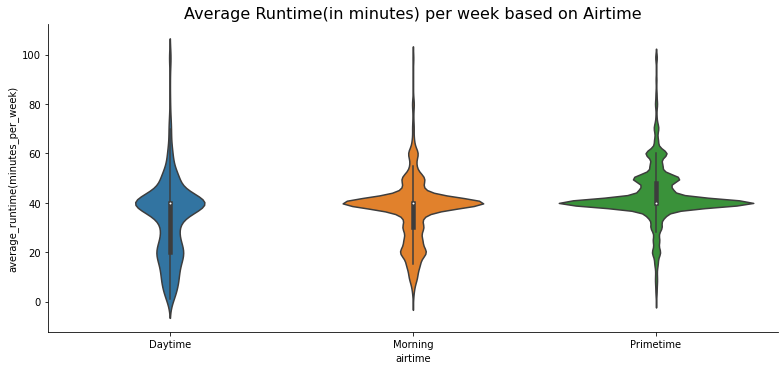

In [13]:
sns.catplot(x='airtime', y='average_runtime(minutes_per_week)', data=train_df, kind='violin', aspect=2.2)
plt.title("Average Runtime(in minutes) per week based on Airtime", fontsize=16)
plt.show()

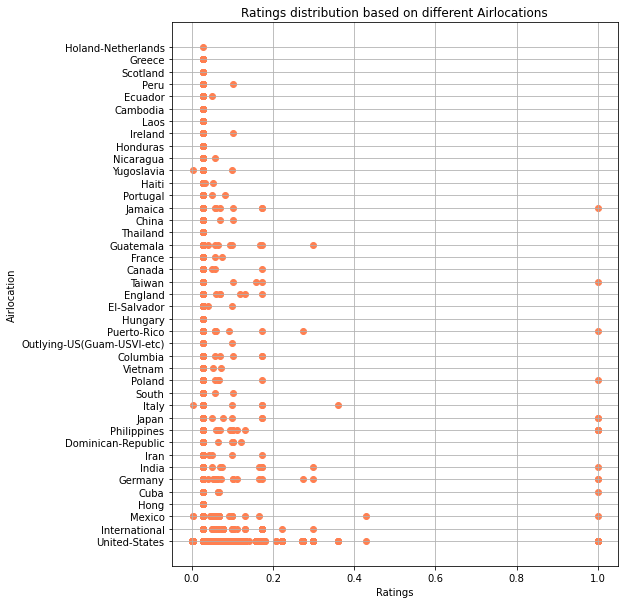

In [14]:
plt.figure(figsize=(8,10))
plt.scatter(x = train_df['ratings'], y = train_df['airlocation'], color="coral")
plt.title("Ratings distribution based on different Airlocations")
plt.grid()
plt.ylabel('Airlocation')
plt.xlabel('Ratings')
plt.show()

## 4. Encoding Categorical to Numerical  <a name="encoding_train"></a>

In [15]:
# Lets convert the categorical columns into numeric to prepare data for model building
dummy_df = pd.get_dummies(train_df.drop(['UserID'], axis=1))
dummy_df.head()

,average_runtime(minutes_per_week),ratings,netgain,relationship_status_Divorced,relationship_status_Married-AF-spouse,relationship_status_Married-civ-spouse,relationship_status_Married-spouse-absent,relationship_status_Never-married,relationship_status_Separated,relationship_status_Widowed,...,airlocation_Taiwan,airlocation_Thailand,airlocation_United-States,airlocation_Vietnam,airlocation_Yugoslavia,expensive_High,expensive_Low,expensive_Medium,money_back_guarantee_No,money_back_guarantee_Yes
0,40,0.027465,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
1,35,0.027465,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,40,0.027465,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
3,40,0.027465,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,50,0.027465,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [16]:
independent = dummy_df.drop(['netgain'], axis=1)
dependent = dummy_df['netgain']
print(independent.shape, dependent.shape)

(19519, 71) (19519,)


## 5. Splitting the data using train_test_split <a name="splitting"></a>

In [17]:
x_train,x_val,y_train,y_val=train_test_split(independent,dependent,test_size=0.3,random_state=1234)

## 6. Model Building <a name="model_building"></a>
We will be using **Logistic Regression, Decision-Tree Classifier and CatBoostRegressor** to get accuracy and F1 scores and select the best one out for building our model on test data.

### 6.1. Logistic Regression <a name="logistic_regression"></a>

In [18]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

#### Accuracy Score

In [19]:
# Let's calculate the accuracy score on train data
log_train_pred = logreg.predict(x_train)
log_train_score= accuracy_score(y_train,log_train_pred)
print('Accuracy score on train data:',log_train_score)

Accuracy score on train data: 0.8013613408475445


In [20]:
# Let's calculate the accuracy score on validation data
log_val_pred = logreg.predict(x_val)
log_val_score= accuracy_score(y_val,log_val_pred)
print('Accuracy score on validation data :',log_val_score)

Accuracy score on validation data : 0.8054986338797814


#### F1 Score

In [21]:
# Calculate the F1 Score on train data
f1_train = f1_score(y_train, log_train_pred)
print("F1 score on train data : ", f1_train)

F1 score on train data :  0.4951636904761906


In [22]:
# Calculate the F1 score on validation data
f1_val = f1_score(y_val, log_val_pred)
print("F1 score on validation data : ", f1_val)

F1 score on validation data :  0.4966858152894388


### 6.2. Decision Tree Classifier <a name="decision_tree_classifier"></a>

In [23]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

DecisionTreeClassifier()

#### Accuracy Score

In [24]:
dtc_train_pred = dtc.predict(x_train)
dtc_train_score= accuracy_score(y_train,dtc_train_pred)
print('Accuracy score on train data :',dtc_train_score)

Accuracy score on train data : 0.8684769084388494


In [25]:
dtc_val_pred = dtc.predict(x_val)
dtc_val_score = accuracy_score(y_val, dtc_val_pred)
print('Accuracy score on validation data : ', dtc_val_score)

Accuracy score on validation data :  0.7935450819672131


#### F1 Score

In [26]:
f1_train = f1_score(y_train, dtc_train_pred)
print("F1 score on train data : ", f1_train)

F1 score on train data :  0.6920308483290489


In [27]:
f1_val = f1_score(y_val, dtc_val_pred)
print("F1 score on validation data : ", f1_val)

F1 score on validation data :  0.5204284014280047


### 6.3. Using CatBoostClassifier <a name="catboost_classifier"></a>

In [28]:
cbr = CatBoostClassifier(eval_metric='AUC', learning_rate=1, iterations=50)

In [29]:
cbr.fit(x_train, y_train)

0:	total: 222ms	remaining: 10.9s
1:	total: 255ms	remaining: 6.11s
2:	total: 278ms	remaining: 4.36s
3:	total: 294ms	remaining: 3.38s
4:	total: 311ms	remaining: 2.8s
5:	total: 353ms	remaining: 2.59s
6:	total: 381ms	remaining: 2.34s
7:	total: 415ms	remaining: 2.18s
8:	total: 437ms	remaining: 1.99s
9:	total: 462ms	remaining: 1.85s
10:	total: 530ms	remaining: 1.88s
11:	total: 552ms	remaining: 1.75s
12:	total: 599ms	remaining: 1.7s
13:	total: 628ms	remaining: 1.61s
14:	total: 661ms	remaining: 1.54s
15:	total: 703ms	remaining: 1.49s
16:	total: 756ms	remaining: 1.47s
17:	total: 793ms	remaining: 1.41s
18:	total: 825ms	remaining: 1.34s
19:	total: 867ms	remaining: 1.3s
20:	total: 918ms	remaining: 1.27s
21:	total: 942ms	remaining: 1.2s
22:	total: 973ms	remaining: 1.14s
23:	total: 1.01s	remaining: 1.09s
24:	total: 1.06s	remaining: 1.06s
25:	total: 1.09s	remaining: 1s
26:	total: 1.14s	remaining: 969ms
27:	total: 1.19s	remaining: 931ms
28:	total: 1.26s	remaining: 910ms
29:	total: 1.29s	remaining: 863

#### Accuracy Score

In [30]:
cbr_train_pred = cbr.predict(x_train)
cbr_train_score= accuracy_score(y_train,cbr_train_pred)
print('Accuracy score on train data :',cbr_train_score)

Accuracy score on train data : 0.8410305203835176


In [31]:
cbr_val_pred = cbr.predict(x_val)
cbr_val_score= accuracy_score(y_val,cbr_val_pred)
print('Accuracy score on validation data :',cbr_val_score)

Accuracy score on validation data : 0.8114754098360656


#### F1 Score

In [32]:
f1_train = f1_score(y_train, cbr_train_pred)
print("F1 score on train data : ", f1_train)

F1 score on train data :  0.6142095914742451


In [33]:
f1_val = f1_score(y_val, cbr_val_pred)
print("F1 score validation data : ", f1_val)

F1 score validation data :  0.5337837837837838


### 6.4. XGBoostClassifier <a name="xgboost_classifier"></a>

In [34]:
xgboost = xgb.XGBClassifier(max_depth=3,learning_rate=0.1)

In [35]:
xgboost.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Accuracy Score

In [36]:
xgb_train_pred = xgboost.predict(x_train)
xgb_train_score= accuracy_score(y_train,xgb_train_pred)
print('Accuracy score on train data :',xgb_train_score)

Accuracy score on train data : 0.8206104076703505


In [37]:
xgb_val_pred = xgboost.predict(x_val)
xgb_val_score = accuracy_score(y_val, xgb_val_pred)
print('Accuracy score on validation data : ', xgb_val_score)

Accuracy score on validation data :  0.820525956284153


#### F1 Score

In [38]:
f1_train = f1_score(y_train, xgb_train_pred)
print("F1 score on train data : ", f1_train)

F1 score on train data :  0.547201182338814


In [39]:
f1_val = f1_score(y_val, xgb_val_pred)
print("F1 score on validation data : ", f1_val)

F1 score on validation data :  0.5444299956653662


## 7. Metrics Comparison <a name="metrics_comparison"></a>

As we can notice from the above tables, **XGBoost has resulted in better Accuracy Scores and Best F1 scores** with the least variation between training and validation data.<br>

***So, we can proceed with XGBoost Classifier to predict the 'netgain' in our Test dataset***

## 8. Read and Encode the test data <a name="read_test_data"></a>

In [40]:
test_df = pd.read_csv("data/test.csv")
test_df.head()


,UserID,realtionship_status,industry,genre,targeted_sex,average_runtime(minutes_per_week),airtime,airlocation,ratings,expensive,money_back_guarantee
0,UI_8772,Never-married,Entertainment,Infomercial,Female,40,Primetime,United-States,0.027465,High,Yes
1,UI_13139,Divorced,Auto,Comedy,Female,40,Primetime,United-States,0.027465,Low,No
2,UI_15381,Married-civ-spouse,Pharma,Infomercial,Male,40,Primetime,United-States,0.027465,High,No
3,UI_15503,Never-married,Auto,Comedy,Male,30,Primetime,United-States,0.027465,High,Yes
4,UI_16556,Never-married,Political,Comedy,Male,70,Morning,United-States,0.027465,Low,No


In [41]:
# Rename the column 'realtionship_status' to 'relationship_status' to use further it without trouble.
test_df.rename(columns={'realtionship_status':'relationship_status'}, inplace=True)

In [42]:
# Let's remove 'UserID' from the data and convert all categorical data into numerical
test = pd.get_dummies(test_df.drop(['UserID'], axis=1))
test.head()

,average_runtime(minutes_per_week),ratings,relationship_status_Divorced,relationship_status_Married-AF-spouse,relationship_status_Married-civ-spouse,relationship_status_Married-spouse-absent,relationship_status_Never-married,relationship_status_Separated,relationship_status_Widowed,industry_Auto,...,airlocation_Taiwan,airlocation_Thailand,airlocation_United-States,airlocation_Vietnam,airlocation_Yugoslavia,expensive_High,expensive_Low,expensive_Medium,money_back_guarantee_No,money_back_guarantee_Yes
0,40,0.027465,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,40,0.027465,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
2,40,0.027465,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
3,30,0.027465,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
4,70,0.027465,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0


## 9. Generating Predictions <a name="predictions"></a>

In [44]:
pred = xgboost.predict(test)

9138     0
3563     0
16696    1
6874     0
1580     0
        ..
8235     0
9463     1
8484     0
17063    1
1320     0
Name: netgain, Length: 13663, dtype: int64


In [145]:
submission = pd.DataFrame()
submission['netgain'] = pred

In [146]:
submission.to_csv('output/submission.csv', index=False)

<div style="color:#EA0B66; font-size: 24px;"><center><h1><a href="#table_of_contents">Go To Top</a></h1></center></div>